# Gunner Farneback's algorithm

- To calculate dense optical flow.

- The dense optical flow will calculate flow for all points in an image

- It will colour them black if no flow (no movement) is detected

In [140]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [141]:
frame = skimage.io.imread('world-of-plants-main.jpg')

In [142]:
frame.shape

(1080, 1920, 3)

96


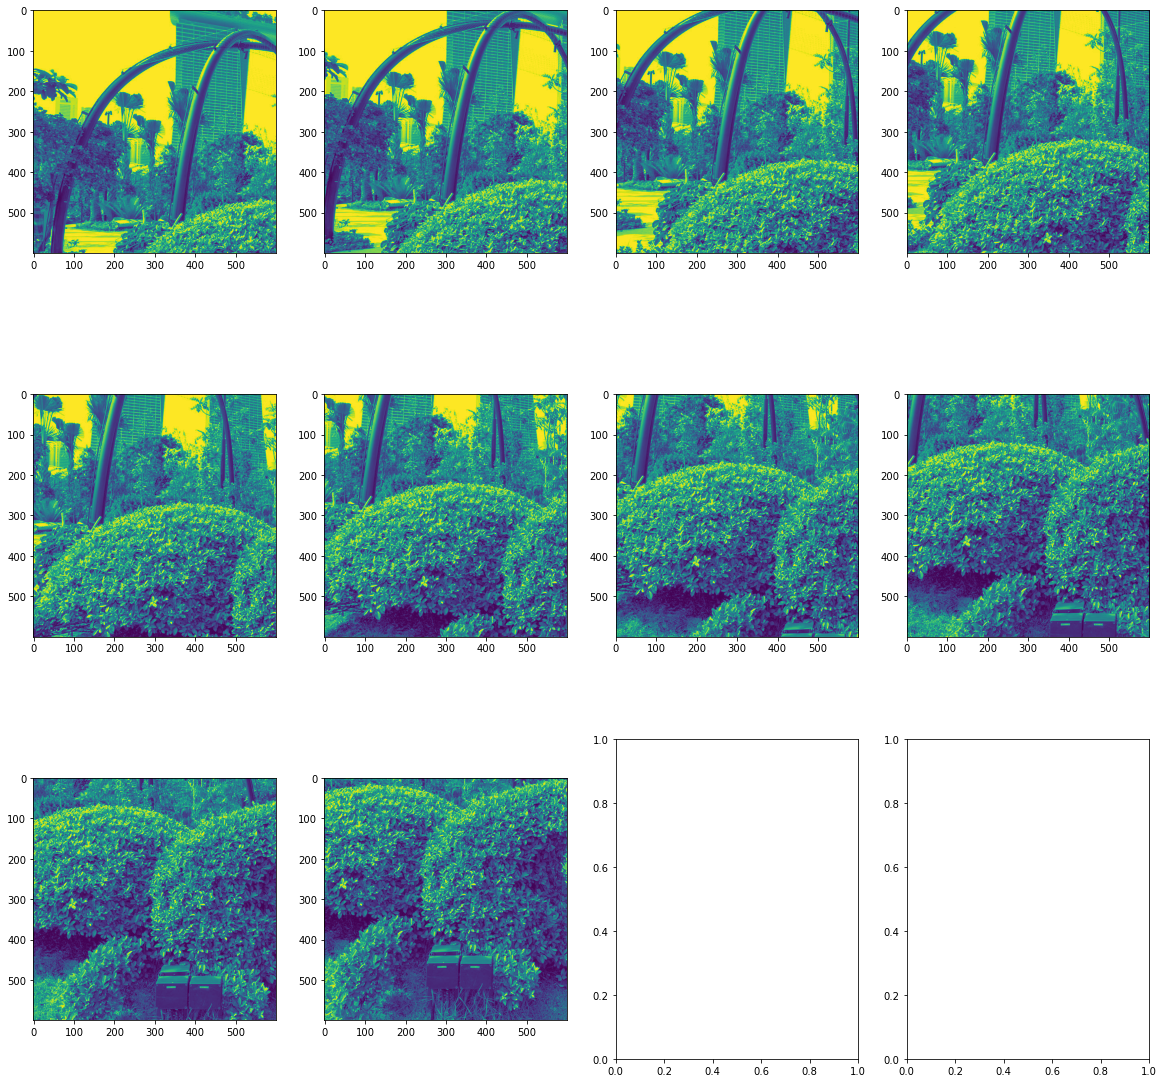

In [143]:
image_frames, coord_list = shift_images(shift_x=5,shift_y=5,frame=frame,dim=600,x0=0,y0=0)
print(len(image_frames))
fig,axes = plt.subplots(ceil(len(image_frames[::10])/4),4,figsize=(20,20)) # plot every 10 image
for ax, im in zip(axes.flatten(),image_frames[::10]):
    ax.imshow(im)

plt.show()

In [144]:
im_stack = np.stack(image_frames,axis=2)
im_stack.shape

(600, 600, 96)

# Using openCV

In [145]:
flow = cv.calcOpticalFlowFarneback(im_stack[:,:,0],im_stack[:,:,1],None,0.5,3,15,3,5,1.2,0)
flow.shape

(600, 600, 2)

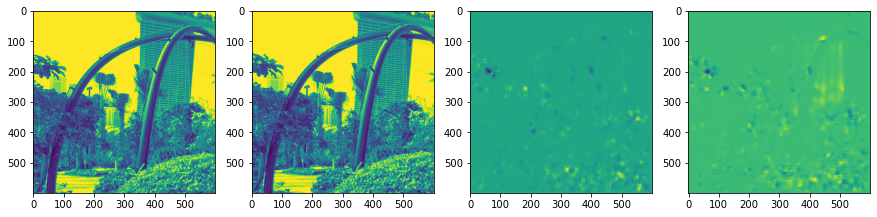

In [146]:
fig, ax = plt.subplots(1,4,figsize=(15,5))
ax[0].imshow(im_stack[:,:,0])
ax[1].imshow(im_stack[:,:,1])
ax[2].imshow(flow[:,:,0])
ax[3].imshow(flow[:,:,1])

In [148]:
hsv_mask = np.zeros((im_stack.shape[0],im_stack.shape[1],3)) #hue saturation value
hsv_mask[:,:,1] = 255 
hsv_mask.shape

bgr_list = []
for i in range(1,im_stack.shape[2]):
    flow = cv.calcOpticalFlowFarneback(im_stack[:,:,i-1],im_stack[:,:,i],None,0.5,3,15,3,5,1.2,0)
    #convert flow from vector to polar coordinates and map the angle to diff colour maps
    mag, ang = cv.cartToPolar(flow[:,:,0],flow[:,:,1],angleInDegrees=True) #input the x and y component of velocity
    hsv_mask[:,:,0] = ang/2 #hue is determined by angle
    hsv_mask[:,:,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX) #value
    rgb = cv.cvtColor(np.float32(hsv_mask),cv.COLOR_HSV2RGB).astype(np.uint8)
    bgr_list.append(rgb)

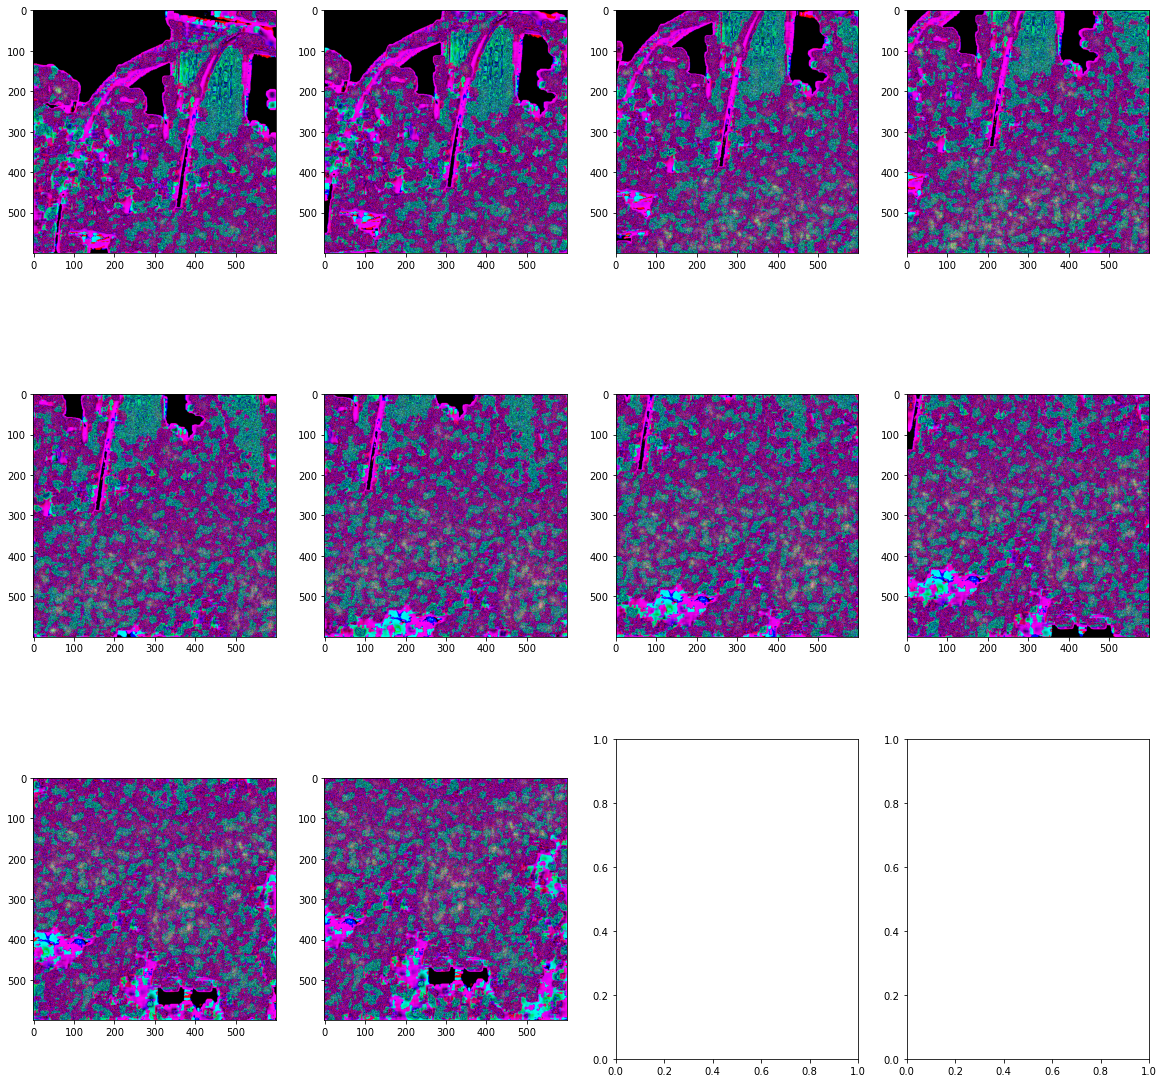

In [149]:
fig,axes = plt.subplots(ceil(len(bgr_list[::10])/4),4,figsize=(20,20)) # plot every 10 image
for ax, im in zip(axes.flatten(),bgr_list[::10]):
    # im_rgb = cv.cvtColor(im,cv.COLOR_BGR2RGB)
    ax.imshow(im)

plt.show()

.....Done!


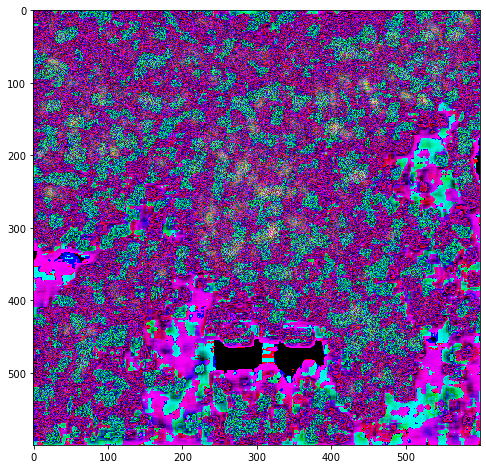

In [150]:
animate_frames(bgr_list,'Gunner_Farneback_gbtb',fps=30)

# Create color wheel for HSV

c:\Users\PAKHUIYING\anaconda3\envs\image_processing\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


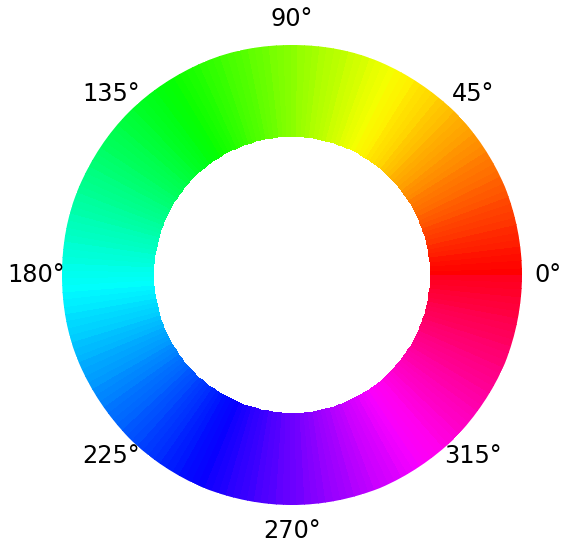

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mpl

# If displaying in a Jupyter notebook:
# %matplotlib inline 

# Generate a figure with a polar projection
fg = plt.figure(figsize=(8,8))
ax = fg.add_axes([0.1,0.1,0.8,0.8], projection='polar')

# Define colormap normalization for 0 to 2*pi
norm = mpl.colors.Normalize(0, 2*np.pi) 

# Plot a color mesh on the polar plot
# with the color set by the angle

n = 200  #the number of secants for the mesh
t = np.linspace(0,2*np.pi,n)   #theta values
r = np.linspace(.6,1,2)        #radius values change 0.6 to 0 for full circle
rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
c = tg                         #define color values as theta value
im = ax.pcolormesh(t, r, c.T,norm=norm,cmap='hsv')  #plot the colormesh on axis with colormap
ax.set_yticklabels([])                   #turn of radial tick labels (yticks)
ax.tick_params(pad=15,labelsize=24)      #cosmetic changes to tick labels
ax.spines['polar'].set_visible(False)    #turn off the axis spine.

# Video Streaming

In [134]:
cap = cv.VideoCapture(0)
ret, frame1 = cap.read()
prvsImg = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY) #convert to grey scale

hsv_mask = np.zeros_like(frame1) #hue saturation value
hsv_mask[:,:,1] = 255 

while True: #video camera streaming
    ret, frame2 = cap.read()
    nextImg = cv.cvtColor(frame2,cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvsImg,nextImg,None,0.5,3,15,3,5,1.2,0)
    #convert flow from vector to polar coordinates and map the angle to diff colour maps
    mag, ang = cv.cartToPolar(flow[:,:,0],flow[:,:,1],angleInDegrees=True) #input the x and y component of velocity
    hsv_mask[:,:,0] = ang/2 #hue is determined by angle
    hsv_mask[:,:,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX) #value
    bgr = cv.cvtColor(hsv_mask,cv.COLOR_HSV2BGR)
    cv.imshow('frame',bgr)
    k=cv.waitKey(10) & 0xFF
    if k == 27: # if we hit the escape key
        break

    prvsImg = nextImg

cap.release()
cv.destroyAllWindows()